In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
Smin, Smax = 50, 200 
K = 100  
T = 0.25
sigma = 0.2 
r = 0.05 

M = 100
N = 100
dS = (Smax - Smin) / M
dt = T / N

In [3]:
def black_scholes(S, K, T, r, sigma, type="call", t=0):
    d1 = (np.log(S / K) + (r + (sigma ** 2) / 2) * (T - t)) / (sigma * np.sqrt(T - t))
    d2 = d1 - sigma * np.sqrt(T - t)

    if type == "call":
        return S * norm.cdf(d1) - K * np.exp(-r * (T - t)) * norm.cdf(d2)
    if type == "put":
        return -S * norm.cdf(-d1) + K * np.exp(-r * (T - t)) * norm.cdf(-d2)

In [4]:
def tridiagonal(C, pU, pM, pD, lambda_L, lambda_U, nj):
    '''
    Helper function for solving the tridiagonal matrix system
    '''
    C1 = np.zeros(2*nj+1)
    pmp = [pM+pD]
    pp = [-pU*C[2]-(pM-2)*C[1]-pD*C[0]+pD*lambda_L]

    for j in range(2, 2*nj):
        pmp.append(pM - pU*pD/pmp[j-2])
        pp.append(-pU*C[j+1] - (pM-2)*C[j] - pD *
                  C[j-1] - pp[j-2]*pD/pmp[j-2])

    # Boundary conditions:
    C1[2*nj] = (pp[len(pp)-1] + pmp[len(pmp)-1]
                * lambda_U)/(pU + pmp[len(pmp)-1])
    C1[2*nj-1] = C1[2*nj] - lambda_U

    # Back substitution
    for j in range(2*nj-2, 0, -1):
        C1[j] = (pp[j-1] - pU*C1[j+1])/pmp[j-1]
    C1[0] = C[0]
    return C1


In [5]:
def crank_nicolson(S, K, T, sigma, r, N, Nj, CallPut):
    '''
    Crank-Nicolson finite difference method for pricing European options
    '''
    dt = T / N
    dx = 1.0 / (2 * Nj + 1)
    nu = r - 0.5 * sigma**2

    pu = -0.25 * dt * ((sigma / dx)**2 + nu / dx)
    pm = 1.0 + 0.5 * dt * (sigma / dx)**2 + 0.5 * r * dt
    pd = -0.25 * dt * ((sigma / dx)**2 - nu / dx)

    St = S * np.exp((np.arange(-Nj, Nj + 1) * dx))
    grid = np.maximum(0, (St - K) if CallPut == 'Call' else (K - St))

    lambdaU = (St[2 * Nj] - K if CallPut == 'Call' else 0)
    lambdaL = (0 if CallPut == 'Call' else K - St[0])

    for _ in range(N):
        grid = tridiagonal(grid, pu, pm, pd, lambdaL, lambdaU, Nj)

    return grid[Nj]

In [6]:
S = np.linspace(Smin, Smax, M+1)
call = np.zeros(M+1)
put = np.zeros(M+1)
call_bs = np.zeros(M // 10 + 1)
put_bs = np.zeros(M // 10 + 1)

for i in range(len(S)):
    call[i] = crank_nicolson(S[i],K,T,sigma,r,N,M,CallPut="Call")
    put[i] = crank_nicolson(S[i],K,T,sigma,r,N,M,CallPut="Put")

    if i % 10 == 0:
        call_bs[i//10] = black_scholes(S[i],K,T,r,sigma,"call")
        put_bs[i//10] = black_scholes(S[i],K,T,r,sigma,"put")

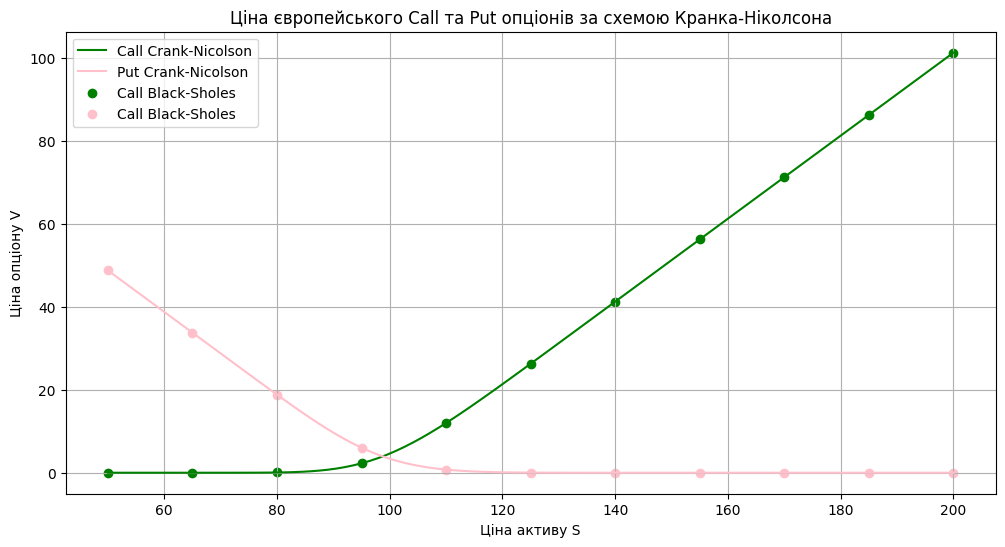

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(S, call, label="Call Crank-Nicolson", color="green")
plt.plot(S, put, label="Put Crank-Nicolson", color="pink")
plt.scatter(S[::10], call_bs, label="Call Black-Sholes", color="green")
plt.scatter(S[::10], put_bs, label="Call Black-Sholes", color="pink")
plt.xlabel("Ціна активу S")
plt.ylabel("Ціна опціону V")
plt.title("Ціна європейського Call та Put опціонів за схемою Кранка-Ніколсона")
plt.legend()
plt.grid(True)
plt.show()